
# Linear Regression in Astronomy with Real SDSS DR18 Data

We'll use real star photometry from the Sloan Digital Sky Survey (SDSS DR18) to predict a given band from other bands using linear regression.

We'll compare:
- Ordinary Least Squares (OLS)
- Ridge (L2) ⇔ Gaussian prior on coefficients
- LASSO (L1) ⇔ Laplace prior on coefficients
- BayesianRidge
- HuberRegressor (robust to outliers)

**Dataset:** SDSS DR18 CSV from Kaggle  
Columns of interest: `u, g, r, i, z` (magnitudes)


In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rng = np.random.default_rng(42)

## 1) Load and filter the dataset

In [416]:

# Path to Kaggle CSV (download from: https://www.kaggle.com/datasets/diraf0/sloan-digital-sky-survey-dr18)
csv_path = "SDSS_DR18.csv"  # <-- adjust path if needed

df = pd.read_csv(csv_path)

df

,objid,specobjid,ra,dec,u,g,r,i,z,run,...,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,1.240000e+18,3.240000e+17,184.950869,0.733068,18.87062,17.59612,17.11245,16.83899,16.70908,756,...,19.96352,19.25145,19.05230,0.479021,0.518483,0.520474,0.508502,0.488969,0.041691,GALAXY
1,1.240000e+18,3.250000e+17,185.729201,0.679704,19.59560,19.92153,20.34448,20.66213,20.59599,756,...,19.92417,20.65535,20.57387,0.573926,0.531728,0.403072,0.999874,0.189495,-0.000814,STAR
2,1.240000e+18,3.240000e+17,185.687690,0.823480,19.26421,17.87891,17.09593,16.65159,16.35329,756,...,19.33645,18.16669,17.78844,0.701666,0.743386,0.770897,0.778642,0.736771,0.113069,GALAXY
3,1.240000e+18,2.880000e+18,185.677904,0.768362,19.49739,17.96166,17.41269,17.20545,17.11567,756,...,17.96176,17.21564,17.12367,0.999818,0.787760,0.745611,0.399718,0.986137,0.000087,STAR
4,1.240000e+18,2.880000e+18,185.814763,0.776940,18.31519,16.83033,16.26352,16.06320,15.97527,756,...,16.85104,16.08275,15.98694,0.999795,0.834450,0.723526,0.712259,0.527055,0.000018,STAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.240000e+18,3.580000e+18,154.077143,55.614066,19.39861,18.35476,18.00348,17.89408,17.81222,2243,...,18.35865,17.90406,17.82489,0.999653,0.999791,0.794516,0.802310,0.537987,-0.000101,STAR
99996,1.240000e+18,3.580000e+18,154.067926,55.635794,19.07703,18.05159,17.78332,17.68976,17.66209,2243,...,18.06198,17.69745,17.67005,0.802407,0.999912,0.999776,0.999682,0.544329,-0.000352,STAR
99997,1.240000e+18,1.070000e+18,153.897018,55.712582,19.07982,17.51349,16.64037,16.24183,15.91180,2243,...,19.05242,17.79391,17.40130,0.859021,0.760212,0.769053,0.772322,0.845797,0.117501,GALAXY
99998,1.240000e+18,6.950000e+17,235.656141,56.297044,17.27528,16.41704,16.11662,15.98858,15.97745,2206,...,16.42854,15.98151,15.97900,0.655041,0.199795,0.481020,0.650008,0.822835,-0.000400,STAR


<Axes: >

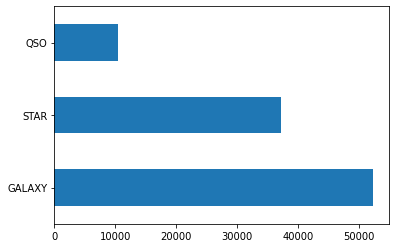

In [417]:
df["class"].value_counts().plot.barh()

In [418]:
# Filter for stars
#df = df[(df['class'] == 'QSO')]
df = df[['u','g','r','i','z']].dropna().sample(1000)

df.head()

,u,g,r,i,z
64220,18.48063,17.03354,16.31576,15.93175,15.65679
6612,19.51635,17.90366,17.29498,17.07694,16.96809
89557,17.77124,16.60803,16.10127,15.82690,15.63415
96783,17.79399,16.46999,15.97116,15.65612,15.48219
7203,18.88947,17.73398,17.57190,17.56710,17.60106


In [419]:
features = ['u', 'g', 'i', 'z']
target = 'r'

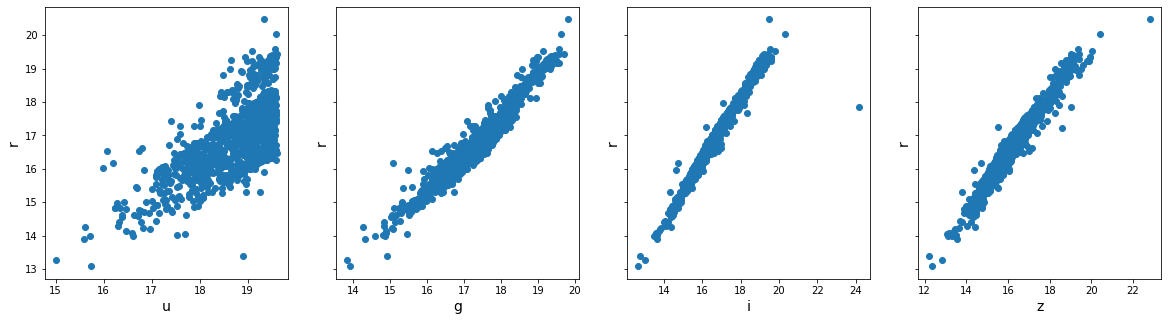

In [420]:
fig, ax = plt.subplots(ncols=len(features), sharey=True, figsize=(5*len(features), 5))
for idx, band in enumerate(features):
    ax[idx].scatter(df[band], df[target])#, c=df['class'])
    ax[idx].set_xlabel(band, fontsize=14)
    ax[idx].set_ylabel(target, fontsize=14)

## 2) Train/test split

In [421]:
X = df[features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((750, 4), (250, 4))

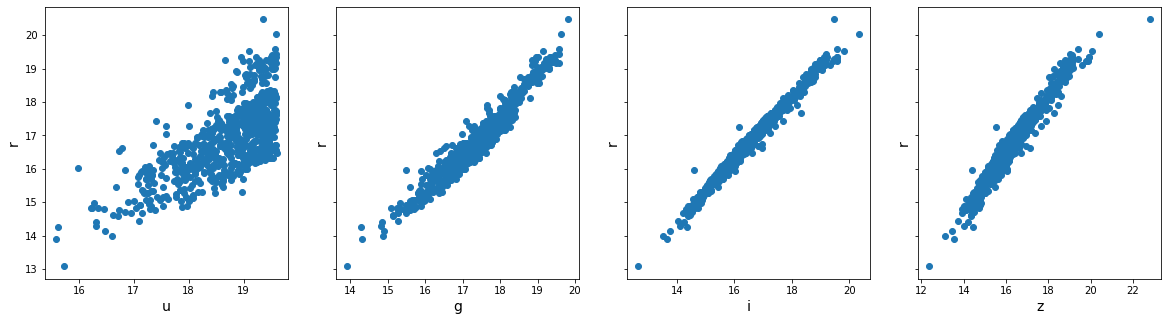

In [422]:
fig, ax = plt.subplots(ncols=len(features), sharey=True, figsize=(5*len(features), 5))
for idx, band in enumerate(features):
    ax[idx].scatter(X_train[band], y_train)
    ax[idx].set_xlabel(band, fontsize=14)
    ax[idx].set_ylabel(target, fontsize=14)

In [423]:
def eval_regressor(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    yhat_tr = model.predict(X_train)
    yhat_te = model.predict(X_test)
    metrics = {
        "model": name,
        "RMSE_train": mean_squared_error(y_train, yhat_tr, squared=False),
        "RMSE_test": mean_squared_error(y_test, yhat_te, squared=False),
        "MAE_test": mean_absolute_error(y_test, yhat_te),
        "R2_test": r2_score(y_test, yhat_te),
    }
    return metrics, yhat_te

## 3) Ordinary Least Squares

In [424]:
ols = make_pipeline(StandardScaler(), LinearRegression())
m_ols, yhat_ols = eval_regressor("OLS", ols, X_train, y_train, X_test, y_test)
m_ols

{'model': 'OLS',
 'RMSE_train': 0.06337831667374955,
 'RMSE_test': 0.1761546198944415,
 'MAE_test': 0.0559526044640845,
 'R2_test': 0.9762676925421414}


## 4) Regularization: Ridge (L2) and LASSO (L1)
- Ridge ⇔ Gaussian prior on coefficients
- LASSO ⇔ Laplace prior on coefficients


In [425]:
ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=42))
lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.01, max_iter=5000, random_state=42))

m_ridge, yhat_ridge = eval_regressor("Ridge(alpha=1.0)", ridge, X_train, y_train, X_test, y_test)
m_lasso, yhat_lasso = eval_regressor("LASSO(alpha=0.01)", lasso, X_train, y_train, X_test, y_test)

m_ridge, m_lasso

({'model': 'Ridge(alpha=1.0)',
  'RMSE_train': 0.06347331728558524,
  'RMSE_test': 0.1764081645397142,
  'MAE_test': 0.05629659115537867,
  'R2_test': 0.9761993261280484},
 {'model': 'LASSO(alpha=0.01)',
  'RMSE_train': 0.07242743956636907,
  'RMSE_test': 0.21650409935747658,
  'MAE_test': 0.06466099423499412,
  'R2_test': 0.9641504145104498})

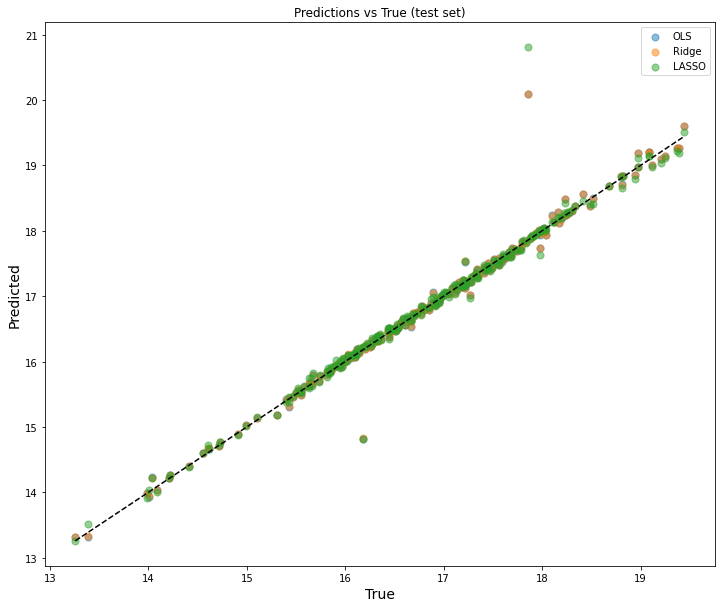

In [426]:
def plot_pred(y_true, preds, labels):
    fig, ax = plt.subplots(figsize=(12, 10))
    for yhat, label in zip(preds, labels):
        ax.scatter(y_true, yhat, s=50, alpha=0.5, label=label)
    lims = [y_true.min(), y_true.max()]
    ax.plot(lims, lims, 'k--')
    ax.set_xlabel("True", fontsize=14)
    ax.set_ylabel("Predicted", fontsize=14)
    ax.set_title("Predictions vs True (test set)")
    #ax.axhline(0, ls=':', c='gray')
    plt.legend()
    plt.show()

plot_pred(y_test.values, [yhat_ols, yhat_ridge, yhat_lasso], ["OLS","Ridge","LASSO"])

## 5) BayesianRidge

In [427]:
bayes = make_pipeline(StandardScaler(), BayesianRidge())
m_bayes, yhat_bayes = eval_regressor("BayesianRidge", bayes, X_train, y_train, X_test, y_test)
m_bayes

{'model': 'BayesianRidge',
 'RMSE_train': 0.06337841296159055,
 'RMSE_test': 0.17615835143425745,
 'MAE_test': 0.05596249723742827,
 'R2_test': 0.9762666870733295}

## 6) Outliers & Robust Loss: Huber

In [428]:
# Copy split
X_train_rb = X_train.copy()
y_train_rb = y_train.copy()

# Inject artificial outliers into training set
n_out = int(0.03 * len(y_train_rb))
idx = rng.choice(len(y_train_rb), size=n_out, replace=False)
y_train_rb.iloc[idx] = y_train_rb.iloc[idx] + rng.normal(0, 20, n_out)

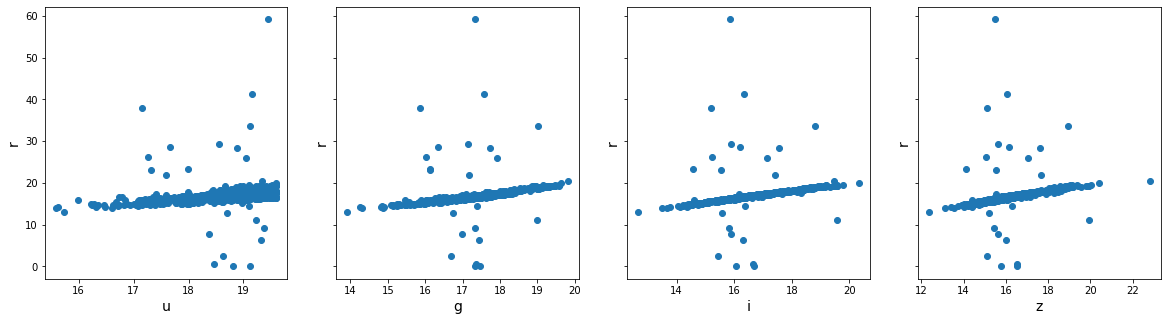

In [429]:
fig, ax = plt.subplots(ncols=len(features), sharey=True, figsize=(5*len(features), 5))
for idx, band in enumerate(features):
    ax[idx].scatter(X_train_rb[band], y_train_rb)
    ax[idx].set_xlabel(band, fontsize=14)
    ax[idx].set_ylabel(target, fontsize=14)

In [ ]:
ols_rb = make_pipeline(StandardScaler(), LinearRegression())
huber = make_pipeline(StandardScaler(), HuberRegressor())

m_ols_rb, yhat_ols_rb = eval_regressor("OLS (with injected outliers)", ols_rb, X_train_rb, y_train_rb, X_test, y_test)
m_huber_rb, yhat_huber_rb = eval_regressor("Huber (with injected outliers)", huber, X_train_rb, y_train_rb, X_test, y_test)
m_huber, yhat_huber = eval_regressor("Huber", huber, X_train, y_train, X_test, y_test)

m_ols_rb, m_huber_rb, m_huber

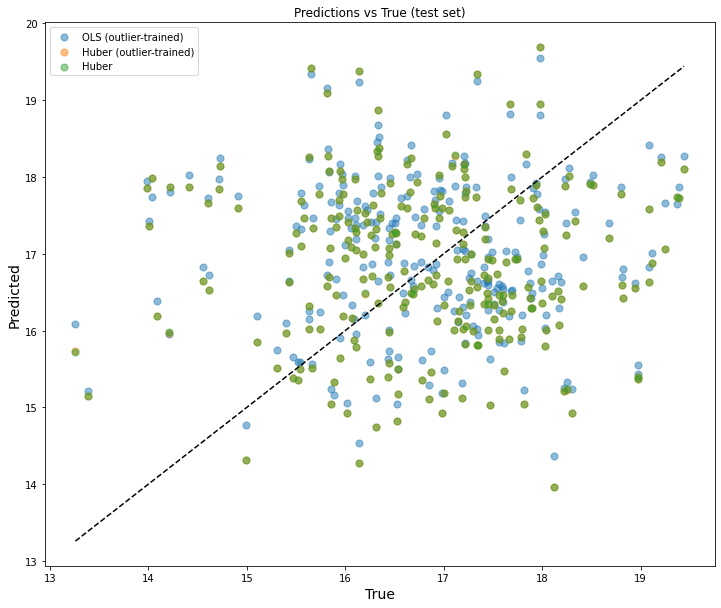

In [430]:
plot_pred(y_test.values, [yhat_ols_rb, yhat_huber_rb, yhat_huber], ["OLS (outlier-trained)","Huber (outlier-trained)", "Huber"])

## 7) Summary Comparison

In [431]:

summary = pd.DataFrame([m_ols, m_ridge, m_lasso, m_bayes, m_ols_rb, m_huber_rb, m_huber])
summary


,model,RMSE_train,RMSE_test,MAE_test,R2_test
0,OLS,0.063378,0.176155,0.055953,0.976268
1,Ridge(alpha=1.0),0.063473,0.176408,0.056297,0.976199
2,LASSO(alpha=0.01),0.072427,0.216504,0.064661,0.964150
3,BayesianRidge,0.063378,0.176158,0.055962,0.976267
4,OLS (with injected outliers),2.656024,0.216129,0.171732,0.954961
5,Huber (with injected outliers),2.662095,0.113304,0.028741,0.987622
6,Huber,0.322394,0.113403,0.028736,0.987600


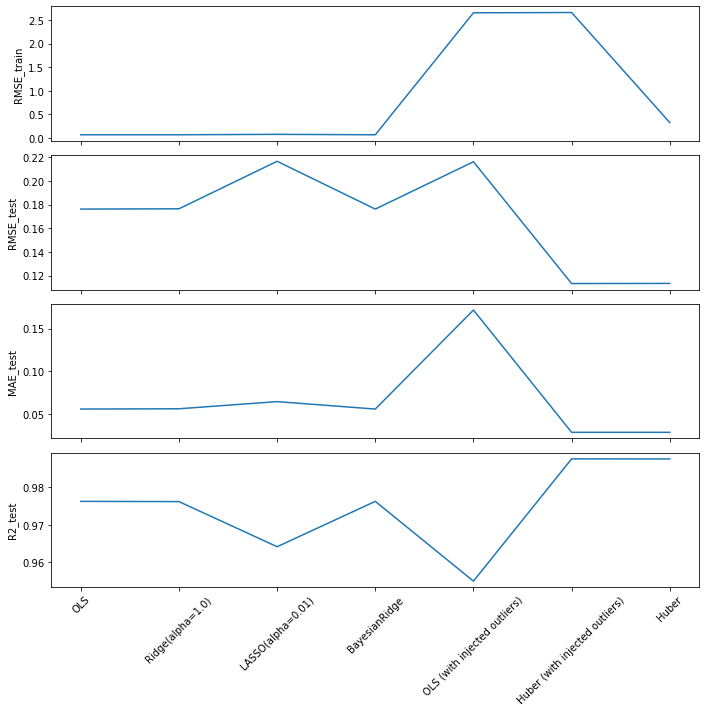

In [432]:

fig, ax = plt.subplots(nrows=len(summary.columns)-1, figsize=(10, 10), sharex=True)
for idx, col in enumerate(summary.columns):
    if idx == 0:
        continue
    ax[idx - 1].plot(summary["model"], summary[col])
    ax[idx - 1].set_ylabel(col)
    ax[idx-1].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()


We repeated the analysis divided by astrophysical class:

In [414]:
# QSO
summary = pd.DataFrame([m_ols, m_ridge, m_lasso, m_bayes, m_ols_rb, m_huber_rb, m_huber])
summary


,model,RMSE_train,RMSE_test,MAE_test,R2_test
0,OLS,0.319239,0.116833,0.045652,0.986839
1,Ridge(alpha=1.0),0.319308,0.117164,0.045212,0.986764
2,LASSO(alpha=0.01),0.319589,0.119173,0.049207,0.986306
3,BayesianRidge,0.319287,0.117083,0.045301,0.986783
4,OLS (with injected outliers),2.656024,0.216129,0.171732,0.954961
5,Huber (with injected outliers),2.662095,0.113304,0.028741,0.987622
6,Huber,0.322394,0.113403,0.028736,0.987600


In [363]:
# Galaxies
summary = pd.DataFrame([m_ols, m_ridge, m_lasso, m_bayes, m_ols_rb, m_huber_rb, m_huber])
summary


,model,RMSE_train,RMSE_test,MAE_test,R2_test
0,OLS,0.052403,0.048647,0.029282,0.997170
1,Ridge(alpha=1.0),0.052768,0.046231,0.028337,0.997444
2,LASSO(alpha=0.01),0.053543,0.049684,0.032000,0.997048
3,BayesianRidge,0.052404,0.048569,0.029250,0.997179
4,OLS (with injected outliers),2.637879,0.181491,0.147498,0.960606
5,Huber (with injected outliers),2.643745,0.037266,0.021225,0.998339
6,Huber,0.066987,0.038036,0.021386,0.998270


In [345]:
# Stars
summary = pd.DataFrame([m_ols, m_ridge, m_lasso, m_bayes, m_ols_rb, m_huber_rb, m_huber])
summary


,model,RMSE_train,RMSE_test,MAE_test,R2_test
0,OLS,0.148056,0.088130,0.032300,0.994018
1,Ridge(alpha=1.0),0.148192,0.087078,0.031052,0.994160
2,LASSO(alpha=0.01),0.161350,0.087300,0.029451,0.994130
3,BayesianRidge,0.148057,0.088055,0.032209,0.994028
4,OLS (with injected outliers),2.643690,0.159750,0.130241,0.980345
5,Huber (with injected outliers),2.646895,0.089219,0.024081,0.993869
6,Huber,0.149757,0.088860,0.024075,0.993919


In [326]:
# All
summary = pd.DataFrame([m_ols, m_ridge, m_lasso, m_bayes, m_ols_rb, m_huber_rb, m_huber])
summary


,model,RMSE_train,RMSE_test,MAE_test,R2_test
0,OLS,0.090229,0.116999,0.044629,0.988251
1,Ridge(alpha=1.0),0.091274,0.118988,0.046182,0.987848
2,LASSO(alpha=0.01),0.095493,0.125563,0.053872,0.986468
3,BayesianRidge,0.090230,0.117045,0.044666,0.988242
4,OLS (with injected outliers),2.629386,0.277311,0.210998,0.933998
5,Huber (with injected outliers),2.642000,0.117975,0.042498,0.988054
6,Huber,0.092820,0.118019,0.042443,0.988046



### Wrap-up
- Ridge/LASSO implement MAP estimation with Gaussian/Laplace priors.
- BayesianRidge estimates priors from data and provides predictive uncertainty.
- HuberRegressor is more robust to outliers than OLS.

**Exercises:**
1. Use cross-validation to tune alpha for Ridge/LASSO.
2. Try QuantileRegressor to explore asymmetric errors.
3. Add colors as features and check performance changes.
